In [1]:
# Notebook behavior:

# Enable multiple outputs from one cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Markdown, Image

# autoreload extension: automaticall refresh imports when code is changed:
%load_ext autoreload
%autoreload 2

# run_cms_analysis.ipynb
---

# Tutorial notebook for processing MCCE microstate file in ms_out folder.

# Required mcce run output files:
### 1. head3.lst
### 2. file in ms_out/, a.k.a. the 'msout file'
 * Notes:
   - The ms_out folder is retained when the `--ms` flag is used at the command line for Step 4: `step4.py --ms`;
   - Format of the msout file name: pHXeHYms.tx at pH point X and Eh point Y;
   - The most typical filename encountered is "pH7eH0ms.txt", meaning the MCCE simulation was a pH titation run at pH7.
---

## Load the needed libraries and modules:

In [3]:
from pathlib import Path
here = Path.cwd()

# Module needed to read the microstate file:
import cms_analysis_wc as msa

---
# Inputs
## Required user input: the path to the msout file:
 * e.g. 4lzt/ms_out/pH7eH0ms.txt
## Optional user input: list of residues of interest
---

# Get the paths to the input files using a folder name and a pH point (as string):

In [4]:
mcce_dir = Path("4lzt")  # local folder
msout_file = "pH7eH0ms.txt"

ph = 7

h3_path = mcce_dir.joinpath("head3.lst")
msout_path = mcce_dir.joinpath("ms_out", msout_file)

outname = f"crgms_corr_ph{ph}"
# Ensure the output directory exists:
output_dir = mcce_dir.joinpath(outname)
if not output_dir.exists():
    output_dir.mkdir()

print(f"h3_path: {str(h3_path)}")
print(f"msout_path: {str(msout_path)}")
print(f"output_dir: {str(output_dir)}")

h3_path: 4lzt/head3.lst
msout_path: 4lzt/ms_out/pH7eH0ms.txt
output_dir: 4lzt/crgms_corr_ph7


# Residues of interest

Note: Make sure to add the names of your residues of interest, such as quinone, here:

### Which kind of residues to consider (3-letter codes)

#### Code for interactive input to obtain `user_resoi`:
Example string to give:  
ASP, pl9 GLU, LYS ARG HIS, TYR NTR PAA, HEM
   
  ```
  user_resoi = msa.split_spunct(input("Enter which kind of residues are of interest, e.g. ASP, HIS:\n"), upper=True)
  ```

In [6]:
# Which kind of residues to consider (3-letter codes):

user_resoi = msa.IONIZABLES
# or:
user_resoi = ["ASP", "HEM", "PL9", "GLU", "HIS", "TYR", "NTR", "CTR"]

residue_kinds = msa.sort_resoi_list(user_resoi)
print("Sorted resoi kinds:", residue_kinds)

Sorted resoi kinds: ['ASP', 'GLU', 'HIS', 'TYR', 'NTR', 'CTR', 'HEM', 'PL9']


In [7]:
# Specific residues of interest for correlation.
# Here, the list supplied must be conformer ids as they appear in the conformers list, without "-" or "+";
# Use helper function above if needed:
choose_res = [
'NTRA0001_',
'LYSA0001_',
'ARGA0005_',
'GLUA0007_',
'LYSA0013_',
'ARGA0014_',
'LYSA0033_',
'GLUA0035_',
'ARGA0045_',
'ASPA0048_',
'ASPA0052_',
'TYRA0053_',
]
print("Chosen resid for correlation (before validation):", choose_res)

Chosen resid for correlation (before validation): ['NTRA0001_', 'LYSA0001_', 'ARGA0005_', 'GLUA0007_', 'LYSA0013_', 'ARGA0014_', 'LYSA0033_', 'GLUA0035_', 'ARGA0045_', 'ASPA0048_', 'ASPA0052_', 'TYRA0053_']


### Populate the conformers list:

In [8]:
conformers = msa.read_conformers(h3_path)
n_conformers = len(conformers)
print(f"Conformers count: {n_conformers:,}")

Conformers count: 270


In [9]:
# validate choose_res:

correl_resids = msa.check_res_list(choose_res, res_lst=residue_kinds, confs_lst=conformers)
print("Valid resid for correlation:", correl_resids)

[WARNING]: check_res_list:
	Removing 'LYSA0001_' from correl_lst: LYS not in residue_kinds.
[WARNING]: check_res_list:
	Removing 'ARGA0005_' from correl_lst: ARG not in residue_kinds.
[WARNING]: check_res_list:
	Removing 'LYSA0013_' from correl_lst: LYS not in residue_kinds.
[WARNING]: check_res_list:
	Removing 'ARGA0014_' from correl_lst: ARG not in residue_kinds.
[WARNING]: check_res_list:
	Removing 'LYSA0033_' from correl_lst: LYS not in residue_kinds.
[WARNING]: check_res_list:
	Removing 'ARGA0045_' from correl_lst: ARG not in residue_kinds.


Valid resid for correlation: ['NTRA0001_', 'GLUA0007_', 'GLUA0035_', 'ASPA0048_', 'ASPA0052_', 'TYRA0053_']


# Instantiate `msa.MSout` class with the given msout file:

In [11]:
mc = msa.MSout(msout_path)
print(mc)


Number of microstates: 1,200,000
Number of unique microstates: 165,386
Energies: lowest_E: -183.93; average_E: -179.92; highest_E: -166.51
Free residues: 41
Fixed residues: 78



#### [ optional ]
#### Learn which methods come with the instantiated class (mc)
 * What's in the MSout class?

### In MCCE, residues are divided into fixed or free residue groups.
 * Only free residues appear in the microstate sate list.
 * Fixed residues can be ionizable residues so we need to include their contribution to the total charge, which is referred to here as __background charge__. 

#### Free residues information

In [ ]:
# Uncomment to display:

#print("mc.free_residues list holds each free residues' conformers.\nSample data:\n", mc.free_residues[:2])

In [12]:
# Save the free_residues in a pandas.DataFrame, it will be one of the inputs to the function msa.ConcaCrgMsPandas:
free_residues_df = msa.free_residues_to_df(mc.free_residues, conformers, colname="Residue")
print(f"Number of free residues: {free_residues_df.shape[0]:,}")

Number of free residues: 41


In [ ]:
# Uncomment to display:

#free_residues_df.head(3)
#free_residues_df.tail(3)

## [ Cat ] RENAMED function `free_res2sumcrg_df` -> `free_res2aver_crg_df`
... because that's what it does

In [13]:
# Get their net charges into a df for later combining with fixed_res

free_res_aver_crg_df = msa.free_res2aver_crg_df(mc.microstates.values(), mc.free_residues, conformers)

In [14]:
# Uncomment to display:

#free_res_aver_crg_df.head()

#### Fixed residues charge.
(Make sure to account for fixed residues charge for MD simulation protonation input.)

__For all fixed residues:__  
```
fixed_residues_info(
    fixed_iconfs: list, conformers: list, res_of_interest: list = IONIZABLES
) -> Tuple[float, pd.DataFrame, dict]:
```

In [15]:
background_crg, all_fixed_res_crg_df, all_fixed_res_crg_dict = msa.fixed_residues_info(mc.fixed_iconfs, conformers)

print("Background charge:", background_crg)
print("Number of fixed residues:", len(all_fixed_res_crg_dict))

Background charge: 10
Number of fixed residues: 20


In [16]:
# Uncomment to display:

#all_fixed_res_crg_df

### Combine free & fixed res with crg and save to csv:

In [19]:
all_res_crg_df = msa.combine_all_free_fixed_residues(free_res_aver_crg_df, all_fixed_res_crg_df)
print(f"{all_res_crg_df.shape = }")

# Save to csv:
# file_name :: all_res_crg_csv -> all_res_crg_status.csv
print("Saving to file.", "Note: The charge is the average charge for residues with 'free' status.", sep="\n")
all_res_crg_df.to_csv(output_dir.joinpath("all_res_crg.csv"), index_label="Residue")

all_res_crg_df.shape = (2, 61)
Saving to file.
Note: The charge is the average charge for residues with 'free' status.


In [18]:
# Uncomment to display:

all_res_crg_df

Residue,NTRA0001_,LYSA0001_,GLUA0007_,HISA0015_,TYRA0020_,SERA0024_,ASNA0027_,GLUA0035_,ASNA0037_,ASNA0039_,...,ARGA0068_,ARGA0073_,ASPA0087_,LYSA0097_,ARGA0112_,ARGA0114_,ASPA0119_,ARGA0125_,ARGA0128_,CTRA0129_
crg,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0
status,free,free,free,free,free,free,free,free,free,free,...,fixed,fixed,fixed,fixed,fixed,fixed,fixed,fixed,fixed,fixed


__For fixed residues among residues of interest:__  
#### Save the fixed residues in your residues of interest to a separate list, DataFrame & csv:

In [20]:
background_crg, fixed_resoi_crg_df, fixed_resoi_crg_dict = msa.fixed_residues_info(mc.fixed_iconfs,
                                                                                   conformers,
                                                                                   residue_kinds)
n_fixed_resoi = fixed_resoi_crg_df.shape[0]
if n_fixed_resoi:
    print("Fixed res in residues of interest:", n_fixed_resoi)
    # save to csv:
    fixed_resoi_crg_df.to_csv(output_dir.joinpath("fixed_crg_resoi.csv"), index=False)
else:
    fixed_resoi_crg_df = None
    print("No fixed residues of interest.")

Fixed res in residues of interest: 6


In [21]:
# Uncomment to display:
print(choose_res)

if n_fixed_resoi:
    fixed_resoi_crg_df

['NTRA0001_', 'LYSA0001_', 'ARGA0005_', 'GLUA0007_', 'LYSA0013_', 'ARGA0014_', 'LYSA0033_', 'GLUA0035_', 'ARGA0045_', 'ASPA0048_', 'ASPA0052_', 'TYRA0053_']


,Residue,crg
0,ASPA0018_,-1
1,TYRA0023_,0
2,TYRA0053_,0
3,ASPA0087_,-1
4,ASPA0119_,-1
5,CTRA0129_,-1


#### The following saves sorted microstates attributes (energy, count and microstate state) into a list;
  * `ms_orig_lst` holds each microstate's attributes sorted by energy.
  * The first attribute is the microstate energy, the second is the multiplicity of that state (mso.microstates holds unique ms info), the last one is the list of conformers in that state.
  * The conformer numbers align with head3.lst. Head3.lst starts at 1; ms lists start at 0.

In [22]:
# mc.sort_microstates() returns a list of ms objects sorted by count, descendingly:

ms_orig_lst = [[ms.E, ms.count, ms.state] for ms in mc.sort_microstates()]

In [24]:
# Sample data (uncomment to display):

#len(ms_orig_lst)
#print(ms_orig_lst[0], ms_orig_lst[1], sep="\n")

### Plot the enthalpy distribution using `msa.ms_energy_histogram`:
   ```
    msa.ms_energy_histogram(ms_by_enrg: list,
                            out_dir: pathlib.Path,
                            save_name: str = 'enthalpy_dist.pdf',
                            show: bool = False)
   ```

[INFO]: ms_energy_histogram:
	Histogram figure saved as 4lzt/crgms_corr_ph7/enthalpy_dist.png


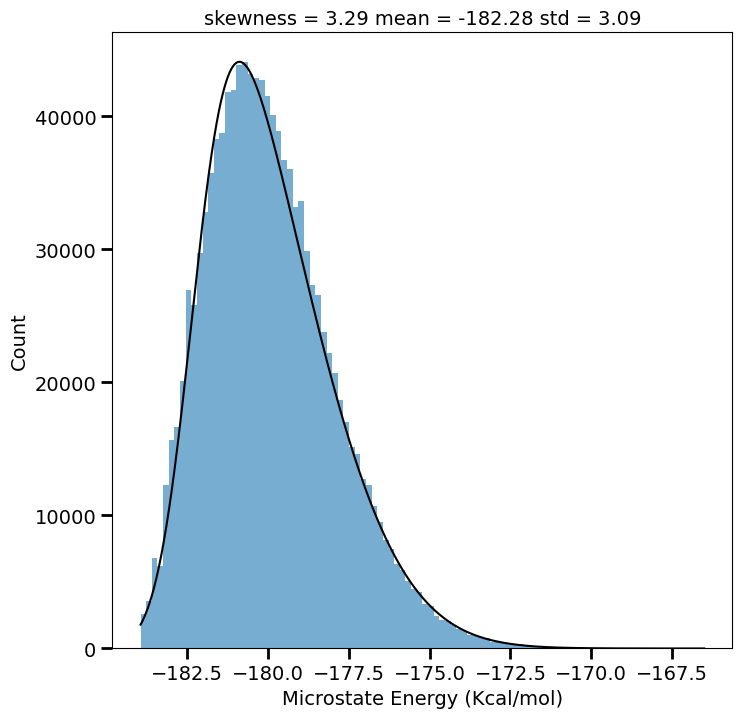

In [25]:
msa.ms_energy_histogram(ms_orig_lst, output_dir, show=True)

---
## Conformer microstates to charge microstates conversion

### This will map the microstate conformer id to its corresponding charge, and convert the conformer microstates from `mc` to charge microstates:

In [26]:
# Map conf index to conf charge:
id_vs_charge = msa.iconf2crg(conformers)

# This list structure is similar to that in ms_orig_lst;
# For each ms, it holds a list = [E, count, [crgms state]], but now the state list gives the charge
# of the free residues coformers:
crg_orig_lst = msa.ms2crgms(ms_orig_lst, id_vs_charge)

In [ ]:
# Sample data (uncomment to display):

#print(crg_orig_lst[:2])

---
# Process the charge microstates into various outputs

## Unfiltered charge microstates
### Note: Outputs of msa.find_uniq_crgms_count_order:
```
  0: all_crg_ms_unique,
  1: all_count,
  2: unique_crg_state_order,
  3: energy_diff_all (used in plot)
```

In [29]:
print("Using unfilteresd charge microstate energies.")

crgms_files = msa.find_uniq_crgms_count_order(crg_orig_lst)

all_crg_count_res = msa.concat_crgms_dfs(crgms_files[0],
                                         crgms_files[1],
                                         crgms_files[2], 
                                         free_residues_df,
                                         background_crg,
                                         res_of_interest=residue_kinds
                                         )

[INFO]: find_uniq_crgms_count_order:
	No energy bounds given: All microstates are selected.
[INFO]: find_uniq_crgms_count_order:
	Number of charge ms: 165,386


Using unfilteresd charge microstate energies.


[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 30


In [30]:
# Sample data (uncomment to display):

print(f"{all_crg_count_res.shape = }")
all_crg_count_res.head()

all_crg_count_res.shape = (30, 12)


Residue,NTRA0001_,GLUA0007_,HISA0015_,TYRA0020_,GLUA0035_,ASPA0048_,ASPA0052_,ASPA0066_,ASPA0101_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,
1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,633591.0,0.528,7.0
2.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,364064.0,0.303,8.0
3.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,118055.0,0.098,8.0
4.0,1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,58285.0,0.049,9.0
5.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,8630.0,0.007,8.0


### This will plot the tautomer charge distribution of unqiue charge microstates based on the occupancy. 
Each dot are unique charge microstate and color coded based on the energy difference of that microstate appear in Monte Carlo run. Total charge is sum of background and free charge (protein charge).

### In `msa.unique_crgms_histogram`, the color variation (hue) indicates the size of the energy range for non-unique crgms. The size of the circle reflects the count.

[INFO]: unique_crgms_histogram:
	Figure saved: 4lzt/crgms_corr_ph7/crgms_logcount_vs_all_E.png


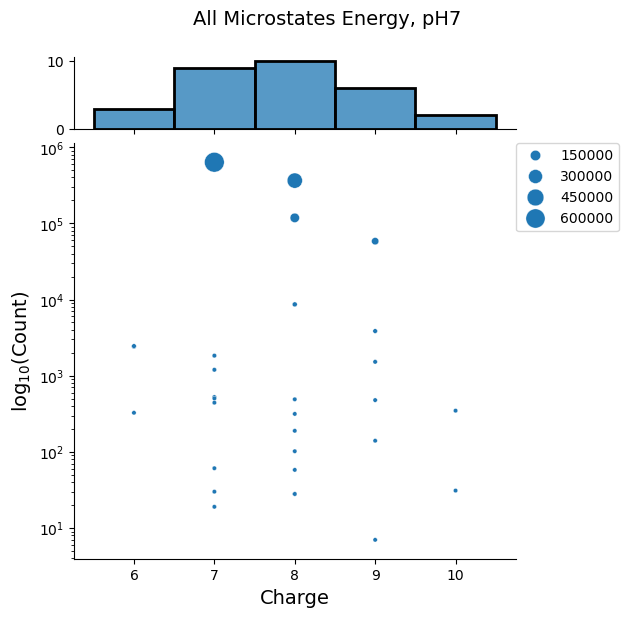

In [32]:
title = f"All Microstates Energy, pH{ph}"
msa.unique_crgms_histogram(crgms_files,
                           background_crg,
                           title,
                           output_dir,
                           save_name="crgms_logcount_vs_all_E.png",
                           show=True)

#### This is to get the unique charge microstates >= lowest energy + 1.36 kcal/mol. 
Make sure your supply list is sorted based on energy in ascending order. 
The order in the dataframe is within the selected energy range.

In [ ]:
# Sample data (uncomment to display):

#lowest_crg_count_res.head(3) 

#### This is to get the unique charge microstates within +/- 0.5 pH unit (+/- 0.68 kcal/mol) of average microstate energy

In [ ]:
# Sample data (uncomment to display):

#av_crg_count_res.head(3) 

#### This is to get the unique charge microstates >= 1 KT unit (1.36 kcal/mol) of highest microstate energy

In [ ]:
# Sample data (uncomment to display):

#high_crg_count_res.head(3) 

### Save all_crg_count_res to a CSV file after adding fixed resoi data:

In [33]:
all_crg_df = msa.add_fixed_res_crg(all_crg_count_res, fixed_resoi_crg_df)

crg_count_csv = output_dir.joinpath("all_crg_count_res.csv")
try:
    all_crg_df.to_csv(crg_count_csv, header=True)
    print(f"DataFrame all_crg_count_res saved to {crg_count_csv!s}.")
except Exception as e:
    print(f"Error occurred while saving all_crg_count_res to csv file: {str(e)}")

DataFrame all_crg_count_res saved to 4lzt/crgms_corr_ph7/all_crg_count_res.csv.


---
# Processing of main crgms data to get the correlation matrix for residues.

In [39]:
correl_resids

['NTRA0001_', 'GLUA0007_', 'GLUA0035_', 'ASPA0048_', 'ASPA0052_', 'TYRA0053_']

In [34]:
df_choose_res_data = msa.choose_res_data(all_crg_df, correl_resids)
df_choose_res_data["Occupancy"] = round(df_choose_res_data["Count"]/sum(df_choose_res_data["Count"]), 2)

file_name = "crg_count_res_of_interest.csv"
df_choose_res_data.to_csv(output_dir.joinpath(file_name), header=True)

In [41]:
# Uncomment to display:

df_choose_res_data[["Count", "Occupancy"]].sum()
df_choose_res_data

Count        1200000.0
Occupancy          1.0
dtype: float64

,NTRA0001_,GLUA0007_,GLUA0035_,ASPA0048_,ASPA0052_,TYRA0053_,Count,Occupancy
0,0.0,-1.0,-1.0,-1.0,-1.0,0,1007336.0,0.84
1,1.0,-1.0,-1.0,-1.0,-1.0,0,178116.0,0.15
2,0.0,-1.0,0.0,-1.0,-1.0,0,12571.0,0.01
3,1.0,-1.0,0.0,-1.0,-1.0,0,1868.0,0.00
4,0.0,0.0,-1.0,-1.0,-1.0,0,109.0,0.00


### Prepare `df_choose_res_data` for msa.WeightedCorr:
 * Filter out fixed res from choose_res list
 * Rename to 1-letter res code + chain + number

In [42]:
# Filter out fixed res:
chosen_free = msa.filter_fixed_from_choose_res(fixed_resoi_crg_df, choose_res)
# Relabel residues with shorter names:
df_chosen_res_renamed = msa.rename_order_residues(df_choose_res_data, chosen_free)

In [43]:
# Uncomment to display:

print(chosen_free)

['NTRA0001_', 'LYSA0001_', 'ARGA0005_', 'GLUA0007_', 'LYSA0013_', 'ARGA0014_', 'LYSA0033_', 'GLUA0035_', 'ARGA0045_', 'ASPA0048_', 'ASPA0052_']


In [44]:
# Relabel residues with shorter names:
df_chosen_res_renamed = msa.rename_order_residues(df_choose_res_data, chosen_free)

In [45]:
# Uncomment to display:

df_chosen_res_renamed

,AE7,AE35,AD48,AD52,ANTR1,Count
0,-1.0,-1.0,-1.0,-1.0,0.0,1007336.0
1,-1.0,-1.0,-1.0,-1.0,1.0,178116.0
2,-1.0,0.0,-1.0,-1.0,0.0,12571.0
3,-1.0,0.0,-1.0,-1.0,1.0,1868.0
4,0.0,-1.0,-1.0,-1.0,0.0,109.0


---
# Weighted correlation
### Define a cutoff if one different from 0.02 (default) is needed.

In [46]:
cutoff = 0.02

df_correlation = msa.WeightedCorr(df=df_chosen_res_renamed,
                                  wcol="Count",
                                  cutoff=cutoff)(method="pearson")

In [47]:
# Uncomment to display:

df_correlation

,AE7,AE35,ANTR1
AE7,1.0,0.0,0.0
AE35,0.0,1.0,0.0
ANTR1,0.0,0.0,1.0


## Create a clustered heatmap to display the residue correlation:

In [48]:
clustered_corr = msa.cluster_corr_matrix(df_correlation)

msa.corr_heatmap(clustered_corr,
                 out_dir=output_dir,
                 save_name="corr_ph7.png",
                 show=True)

[WARNING]: corr_heatmap:
	All off-diagonal correlation values are 0.00: not plotting.
